Многие пользователи он-лайн платформ обучения начинают обучение и не доходят до конца. Попробуем разобраться и проанализировать поведение пользователей. Такой показатель называется success_rate.

В финале сравним показатели ушедших пользователей и тех кто успешно закончил обучение.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(rc={'figure.figsize': (10, 6)})

In [3]:
# загрузим исходные данные
event = pd.read_csv('event_data_train.csv')
event.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


- step_id - id шага
- user_id - анонимизированный id юзера
- timestamp - время наступления события в формате unix date
- action - событие, возможные значения: 
  - discovered - пользователь перешел на шаг
  - viewed - просмотр шага,
  - started_attempt - начало попытки решить шаг
  - passed - удачное решение практического шага

In [4]:
# данные по прохождению курса
submit = pd.read_csv('submissions_data_train.csv')
submit.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


- step_id - id шага
- timestamp - время отправки решения в формате unix date
- submission_status - статус решения
- user_id - анонимизированный id юзера

# Задача

Нужно найти ответы на вопросы:
- Сколько уникальных шагов прошел пользователь
- Сколько он правильно решил заданий
- Сколько дней он провел на платформе
- Как эти показатели различаются у пользователей которые успешно прошли весь курс и которые курс бросили

Посмотрим на наши данные

In [5]:
event.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [6]:
event['action'].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [7]:
event['action'].value_counts()

viewed             1830830
discovered          689495
passed              650331
started_attempt     310047
Name: action, dtype: int64

Присутствует достаточно сильный дисбаланс классов - нужно будет учесть это при моделировании.

Преобразуем время к привычному человекочитаемому формату

In [8]:
event['date'] = pd.to_datetime(event['timestamp'])
event.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,1970-01-01 00:00:01.434340848
1,32815,1434340848,passed,17632,1970-01-01 00:00:01.434340848
2,32815,1434340848,discovered,17632,1970-01-01 00:00:01.434340848
3,32811,1434340895,discovered,17632,1970-01-01 00:00:01.434340895
4,32811,1434340895,viewed,17632,1970-01-01 00:00:01.434340895


Получилась ерунда, потому что формат автоматом был не распознан. Необходимо указать в явном виде, что имеем дело с секундами.

In [9]:
event['date'] = pd.to_datetime(event['timestamp'], unit='s')
event.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


Давайте вынесем отдельно день, и посмотрим активность на курсе - сколько регистрировалось пользователей по дням

In [10]:
event['day'] = event['date'].dt.date
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [11]:
event.groupby('day')['user_id'].nunique().head()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

В табличном виде анализировать довольно не удобно. Давайте построим график для первоначальной оценки.

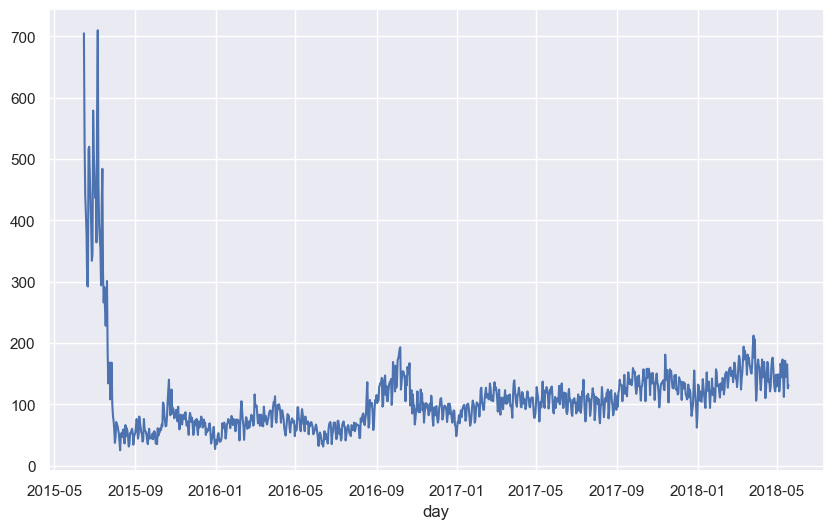

In [12]:
event.groupby('day')['user_id'].nunique().plot(figsize=(10, 6));

Выбросов вроде не наблюдается. В начале есть высокая активность, но она может быть связана с рекламной кампанией.

Инсайт - это был запуск новой программы и работа рекламщиков.

Давайте теперь посмотрим распределение активностей по пользователям

In [13]:
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Отберем события с `action` == `passed`, сгруппируем по пользователю и для `step_id` посчитаем количество вхождений 

Шаг 1 - Не правильное решение!

In [14]:
event[event['action']=='passed'] \
    .groupby('user_id', as_index=False) \
        .agg({'step_id': 'count'}).head()

,user_id,step_id
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Сейчас у нас колонка `step_id` на самом деле количество пройденных шагов. Причем даже если пользователь решил один шаг 87 раз - то в этой колонке он будет отражен 87.

Давайте ее переименуем в `passed_steps`

In [15]:
event[event['action']=='passed'] \
    .groupby('user_id', as_index=False) \
        .agg({'step_id': 'count'}) \
            .rename(columns={'step_id': 'passed_steps'}) \
                .head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Посмотрим на результат

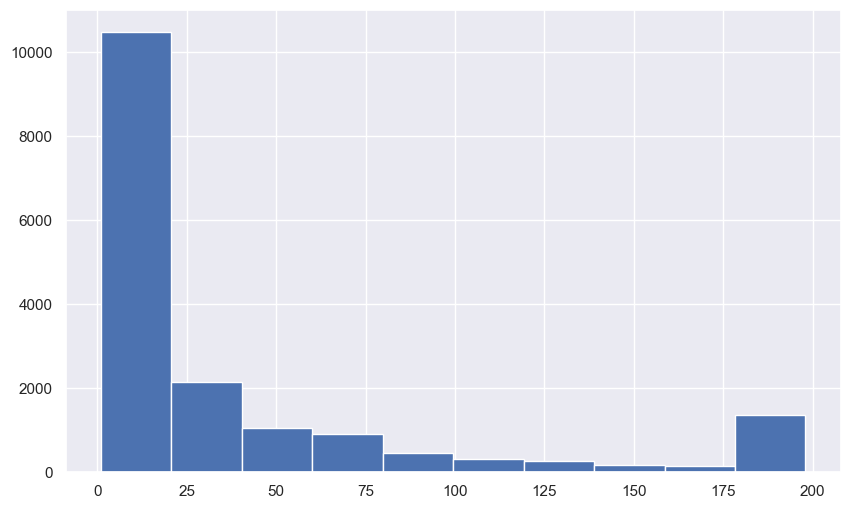

In [16]:
event[event['action']=='passed'] \
    .groupby('user_id', as_index=False) \
        .agg({'step_id': 'count'}) \
            .rename(columns={'step_id': 'passed_steps'}) \
                ['passed_steps'] \
                    .hist();

Шаг 2 - Правильное решение.

Обратите внимание, пользователи, у которых нет ни одного passed шага вообще не попадут в результат

In [17]:
# всего уникальных пользователей
event['user_id'].nunique()

19234

In [18]:
# уникальных пользователей в нашей группировке
event[event['action']=='passed'] \
    .groupby('user_id', as_index=False) \
        .agg({'step_id': 'count'}) \
            .rename(columns={'step_id': 'passed_steps'}) \
                ['user_id'] \
                    .nunique()

17262

сгруппируем пользователей по их действиям, но оставим нулевые значения

In [19]:
event.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [20]:
event.pivot_table(index='user_id',
                  columns='action',
                  values='step_id',
                  aggfunc='count',
                  fill_value=0,) \
                    .head()

action,discovered,passed,started_attempt,viewed
user_id,,,,
1,1,0,0,1
2,9,9,2,10
3,91,87,30,192
5,11,11,4,12
7,1,1,0,1


выберем только прохождение заданий

In [21]:
event.pivot_table(index='user_id',
                  columns='action',
                  values='step_id',
                  aggfunc='count',
                  fill_value=0,)['passed']

user_id
1         0
2         9
3        87
5        11
7         1
         ..
26790     8
26793     0
26794    69
26797    10
26798    12
Name: passed, Length: 19234, dtype: int64

In [22]:
# можно убрать многоуровневое индексирование
event.pivot_table(index='user_id',
                  columns='action',
                  values='step_id',
                  aggfunc='count',
                  fill_value=0,) \
                    .reset_index() \
                        .head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


Построим "правильную" гистограмму активностей пользователей

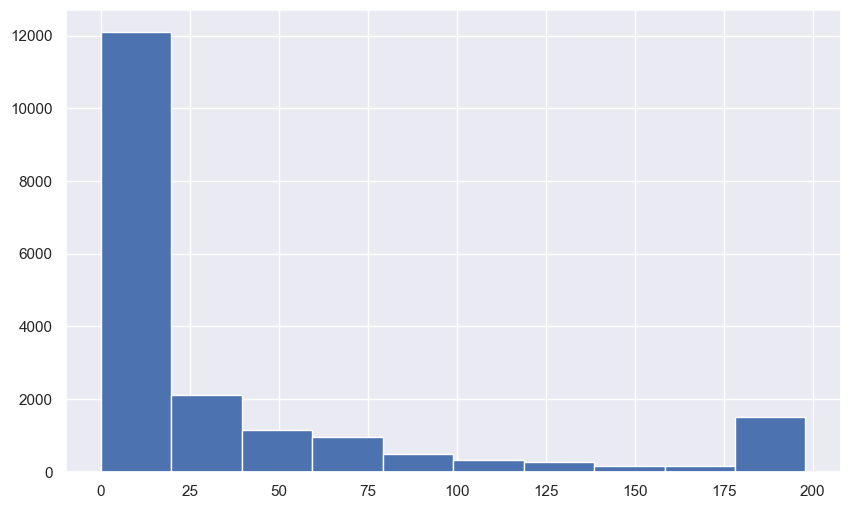

In [23]:
event.pivot_table(index='user_id',
                  columns='action',
                  values='step_id',
                  aggfunc='count',
                  fill_value=0,) \
                    .reset_index() \
                    ['discovered'] \
                    .hist();

Подготовим таблицу `submit`

In [24]:
submit.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [25]:
submit['submission_status'].value_counts()

wrong      286399
correct    222705
Name: submission_status, dtype: int64

In [26]:
submit['date'] = pd.to_datetime(submit['timestamp'], unit='s')
submit['day'] = submit['date'].dt.date
submit.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Посмотрим как успешно (за сколько попыток) пользователи проходили задания

In [27]:
submit.pivot_table(index='user_id',
                   columns='submission_status', 
                   values='step_id', 
                   aggfunc='count',
                   fill_value=0) \
                   .reset_index()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [28]:
user_scores = submit.pivot_table(index='user_id',
                   columns='submission_status', 
                   values='step_id', 
                   aggfunc='count',
                   fill_value=0) \
                   .reset_index()

Давайте соберем некоторые метрики из наших данных. 
- Сколько уникальных шагов прошел пользователь
- Сколько он правильно решил заданий
- Сколько дней он провел на платформе
- Как эти показатели различаются у пользователей которые успешно прошли весь курс и которые курс бросили

Какого пользователя считать drop?

Давайте посмотрим как "в среднем" распределена величина перерывов в занятиях у пользователей курса

In [29]:
event.columns

Index(['step_id', 'timestamp', 'action', 'user_id', 'date', 'day'], dtype='object')

In [30]:
# посмотрим на активность пользователей
event[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']).head(10)

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230
121,5681,2015-06-15,1434342656
128,19739,2015-06-15,1434342747
131,9244,2015-06-15,1434342783
149,6640,2015-06-15,1434342979
189,18272,2015-06-15,1434343275


соберем активность пользователей по дням

In [31]:
event[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
        .groupby('user_id')['timestamp'] \
        .apply(list) \
            .head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [32]:
a = [1, 3, 7, 10]
np.diff(a)

array([2, 4, 3])

Теперь соберм паузы в обучении между днями активности пользователей

In [33]:
event[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
        .groupby('user_id')['timestamp'] \
        .apply(list) \
        .apply(np.diff) \
        .head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

соберем эти списки в один массив и объединим значения

In [34]:
gap_date = event[['user_id', 'day', 'timestamp']] \
    .drop_duplicates(subset=['user_id', 'day']) \
        .groupby('user_id')['timestamp'] \
        .apply(list) \
        .apply(np.diff) \
        .values

gap_date[:10]

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]),
       array([33702812]), array([], dtype=int64), array([863484]),
       array([], dtype=int64), array([], dtype=int64),
       array([], dtype=int64),
       array([   50930,   169538,   198580,    60037,   107104,    64636,
                 87453,    87297,   198829,  3800882,  1728353,  4821849,
               2937859, 61161071,   868834,   629440,   166132,   176429,
                 97665,    74877])                                       ],
      dtype=object)

In [35]:
gap_date=pd.Series(np.concatenate(gap_date, axis=0))


In [36]:
gap_date[:10]

0     4843602
1     6899249
2      182484
3       93710
4     2768870
5      171400
6       78712
7    33702812
8      863484
9       50930
dtype: int64

In [37]:
# посмотрим в сутках
gap_date = gap_date / (24 * 60 * 60)

In [38]:
gap_date[:10]

0     56.060208
1     79.852419
2      2.112083
3      1.084606
4     32.047106
5      1.983796
6      0.911019
7    390.078843
8      9.994028
9      0.589468
dtype: float64

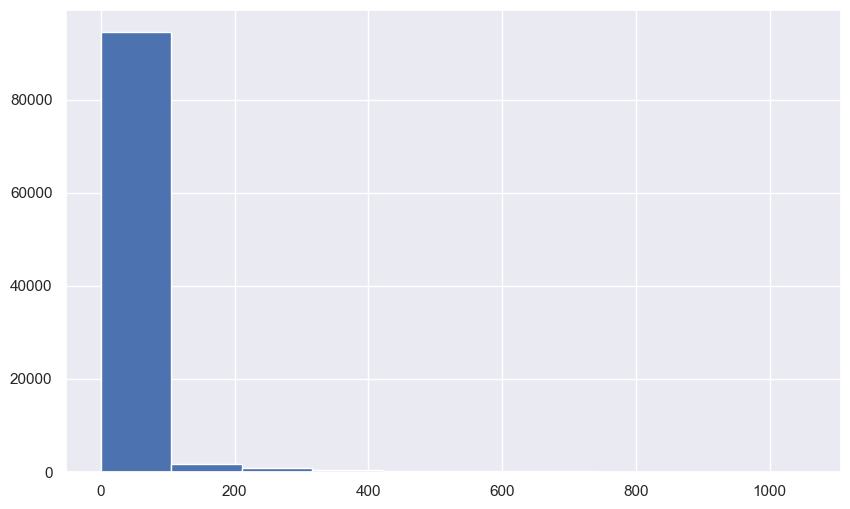

In [39]:
gap_date.hist();

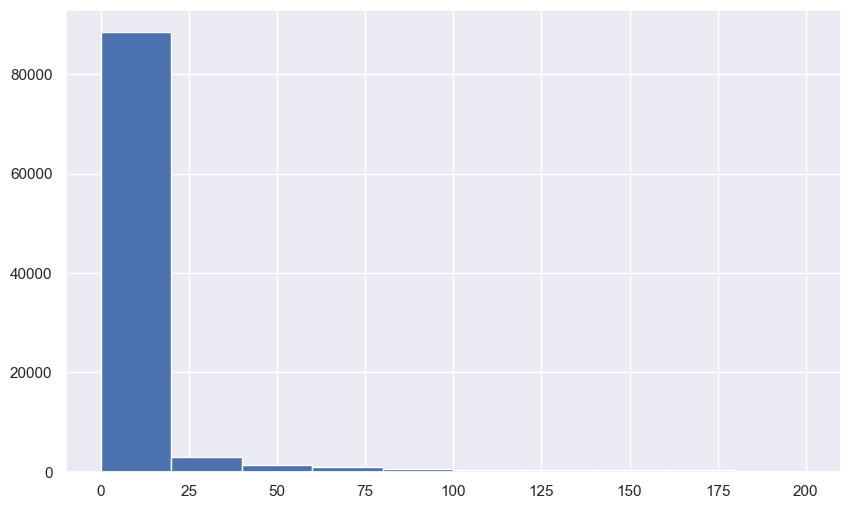

In [40]:
gap_date[gap_date < 200].hist();

В какое количество дней укладывается 95% перерывов

In [41]:
gap_date.quantile(0.95).__round__(0)

60.0

Т.е только 5% пользователей возвращается к учебе после перерыва в 60 дней.

In [42]:
gap_date.quantile(0.90).__round__(0)

18.0

НО, 90% пользователей укладывается в 18 дней перерыва. Разброс очень большой и необходимо принять решение каких пользователей мы будем считать покинувшими курс.

Будем считать ушедшими пользователей, которые не появлялись более 30 дней, что подтверждено 93% пользователей.

In [43]:
gap_date.quantile(0.93).__round__(0)

35.0

Давайте разметим наших пользователей на ушедших и нет. Но обратите внимание, если пользователь прошел курс и больше не появляется - то он не "ушедший", а успешно закончивший.

In [44]:
# посмотрим максимальную дату
event[['day', 'timestamp']].max()

day          2018-05-19
timestamp    1526772811
dtype: object

In [45]:
# посчитаем для каждого пользователя
users_date = event.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}) \
    .rename(columns={'timestamp': 'last_timestamp'}) 

In [46]:
last = 1526772811
drop_out_treshhold = 30 * 24 * 60 * 60

In [47]:
users_date['is_gone'] = (last - users_date['last_timestamp']) > drop_out_treshhold

In [48]:
users_date.head()

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Теперь нужно добавить условие, что данные пользователи не закончили курс и ушли с него до окончания

1. Добавим информацию о прохождении курса

In [49]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [50]:
users_date.merge(user_scores).head()

,user_id,last_timestamp,is_gone,correct,wrong
0,2,1519226966,True,2,0
1,3,1444581588,True,29,23
2,5,1499859939,True,2,2
3,8,1481466913,True,9,21
4,14,1436368676,True,0,1


Внимание - мы опять потеряли данные!

В таблице `user_scores` отсутствуют пользователи, которые вообще не делали попыток решить задание.

И явно укажем колонку по которой происходит слияние данных. Пропущенные значения заполним 0.

In [51]:
users_date.merge(user_scores, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [52]:
users_date.merge(user_scores, on='user_id', how='outer').fillna(0).head()

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [53]:
users_date = users_date.merge(user_scores, on='user_id', how='outer').fillna(0)
users_date.head()

,user_id,last_timestamp,is_gone,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [54]:
event.pivot_table(index='user_id',
                    columns='action',
                    values='step_id',
                    aggfunc='count',
                    fill_value=0,) \
                    .reset_index() \
                    .head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [55]:
# Прикрутим информацию про остальные события
users_events_date = event.pivot_table(index='user_id',
                                        columns='action',
                                        values='step_id',
                                        aggfunc='count',
                                        fill_value=0,) \
                                        .reset_index()

In [56]:
users_events_date.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [57]:
users_date.merge(users_events_date, on='user_id', how='outer').head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [58]:
users_date = users_date.merge(users_events_date, on='user_id', how='outer')

Сколько дней пользователь был на платформе?

In [59]:
event.groupby('user_id') \
    ['day'] \
        .nunique() \
            .head()

user_id
1    1
2    2
3    7
5    2
7    1
Name: day, dtype: int64

In [60]:
users_days = event.groupby('user_id')['day'].nunique().to_frame().reset_index()
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [61]:
users_date.merge(users_days, on='user_id', how='outer').rename(columns={'day': 'days'}).head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [62]:
# Созраним итоговый результат
users_date = users_date.merge(users_days, on='user_id', how='outer').rename(columns={'day': 'days'})

Проверяем, что в процессе подготовки данных мы не потеряли информацию

In [63]:
event['user_id'].nunique()

19234

In [64]:
users_date['user_id'].nunique()

19234

Закончил ли пользователь курс? Будем считать окончивших по пройденным шагам. Больше 170 шагов - курс зачтен.

In [65]:
users_date['passed_course'] = users_date['passed'] > 170

In [67]:
users_date.head()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Итоговая таблица - как отличаются показатели ушедших пользователей и закончивших курс?

In [68]:
users_date.groupby('passed_course').count()

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,days
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [69]:
users_date.to_csv('users_date.csv', index=False)